# Курсовой проект для курса "Python для Data Science"

**Материалы к проекту (файлы)**: train.csv, test.csv.

**Задание**: используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать цены для квартир из файла test.csv.

**Целевая переменная**: Price.

**Основная метрика**: R2 - коэффициент детерминации (sklearn.metrics.r2_score).

**Вспомогательная метрика**: MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error).

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, r2_score as r2
from sklearn.model_selection import train_test_split

In [2]:
random_state = 42

## Предварительный анализ признаков

Загрузим данные по квартирам для обучения и исправим опечатку в названии признака *Healthcare_2*.

In [3]:
data = pd.read_csv('train.csv')
data.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Healthcare_2     10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.4+ MB


Признаки *LifeSquare*, *Healthcare_1* содержат пропущенные значения, которые потребутся заполнить, если эти признаки будут включены в модель.

Признаки *Ecology_2*, *Ecology_3*, *Shops_2* являются бинарными, однако их значения не являются числовыми, что также необходимо будет обработать:

In [5]:
binary_features = ['Ecology_2', 'Ecology_3', 'Shops_2']

for feature in binary_features:
    print('{}\n'.format(data[feature].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Исправим две опечатки в значения признака *HouseYear*. Первая (4968) - это явно 1968 год, вторая (20052011) - либо срок строительства, либо ошибка. Заменим данное значение на 2011 год.

In [6]:
np.sort(data.HouseYear.unique())

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [7]:
index_20052011 = data.loc[data.HouseYear == 20052011].index
index_4968 = data.loc[data.HouseYear == 4968].index

data.loc[index_20052011, 'HouseYear'] = 2011
data.loc[index_4968, 'HouseYear'] = 1968

Рассмотрим признак *Rooms*, обработка которого по итогу всех проведенных исследований оказалась полезной для модели.

Найдем количества принимаемых им значений по всей обучающей выборке:

In [8]:
data.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Найдем среднюю площадь квартир (признак *Square*) в зависимости от количества комнат:

In [9]:
data[['Square', 'Rooms']].groupby('Rooms').mean().rename(columns={'Square': 'mean square'})

,mean square
Rooms,
0.0,81.620358
1.0,41.323277
2.0,56.788214
3.0,76.903234
4.0,98.377544
5.0,122.614941
6.0,59.414334
10.0,59.964120
19.0,42.006046


Судя по всему, значения признака *Rooms* меньше 1 и больше 5 могут быть ошибочными. При обработке они будут заменены - например, медианой признака.

Рассмотрим также распределение целевого признака *Price*, построив его гистограмму:

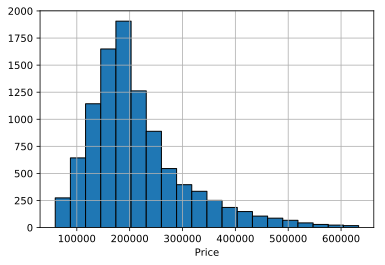

In [10]:
data.Price.hist(bins=20, ec='k')
plt.xlabel('Price')
plt.show()

Можно отметить то, что распределение имеет б**о**льший хвост на дорогих квартирах.

### Разбиение и обработка данных

Выделим 33% процентов обучающей выборки в качестиве валидационной:

In [11]:
train, valid = train_test_split(data, test_size=0.33, random_state=random_state)

Найдем медиану признака *Rooms*.

In [12]:
rooms_median = train.Rooms.median()

rooms_median

2.0

Составим функцию prepare_data() для обработки данных. Включим в нее из наиболее проявивших себя вариантов обработки:
* замену в признаке *Rooms* значений меньше 1 и больше 5 медианой признака;
* замену пропусков в признаке *Healthcare_1* нехарактерным значением -1;
* замену в бинарных признаках *Ecology_2*, *Ecology_3*, *Shops_2* значений A на 0, B на 1.

Применим эту функцию к обучающей и валидационной выборкам.

In [13]:
def prepare_data(df):
    df.loc[(df.Rooms < 1) | (df.Rooms > 5), 'Rooms'] = rooms_median
    df.Healthcare_1 = df.Healthcare_1.fillna(-1)  
    df.loc[:, binary_features] = df.loc[:, binary_features].replace({'A': 0, 'B': 1})
    return df

In [14]:
train = prepare_data(train)
valid = prepare_data(valid)

Выявим признаки, наиболее коррелирующие с целевым признаком *Price*: 

In [15]:
corrs = train.corr()

corrs[corrs.abs() > 0.05].Price[1:-1].sort_values(ascending=False)

Rooms            0.571539
Square           0.532682
DistrictId       0.265550
Social_1         0.262475
Healthcare_2     0.256070
Social_2         0.236178
Shops_1          0.184428
Healthcare_1     0.177085
Floor            0.129609
HouseFloor       0.088874
Social_3         0.077696
LifeSquare       0.069227
Shops_2          0.063139
Ecology_3       -0.052338
Ecology_1       -0.068091
KitchenSquare         NaN
HouseYear             NaN
Ecology_2             NaN
Name: Price, dtype: float64

### Настройка и обучение модели

В  качестве модели выберем случайный лес из 100 деревьями максимальной глубиной в 15:

In [16]:
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=random_state, n_jobs=-1)

Как наиболее результативные для модели были отобраны следующие признаки:

In [17]:
features = ['Rooms', 'Square', 'Healthcare_2', 'Floor', 'HouseFloor', 'Healthcare_1', 'KitchenSquare', 
            'DistrictId', 'HouseYear', 'Social_1', 'Social_2', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Shops_1', 'Shops_2']

In [18]:
rf.fit(train.loc[:, features], train.Price)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Посмотрим важность признаков в обучении модели:

In [19]:
importances = rf.feature_importances_

pd.Series(importances, index=features).sort_values(ascending=False)

Square           0.417578
Social_1         0.109422
Social_2         0.107679
Rooms            0.070345
DistrictId       0.061559
Ecology_1        0.042110
HouseYear        0.040508
Healthcare_1     0.032306
Floor            0.030642
KitchenSquare    0.027443
HouseFloor       0.023079
Shops_1          0.022192
Healthcare_2     0.012042
Shops_2          0.001321
Ecology_3        0.001288
Ecology_2        0.000486
dtype: float64

Оценим по К2 и MSE работу модели на обучающей и валидационной выборках:

In [20]:
def get_prediction(model, df, features=features, evaluate=True):
    pred = model.predict(df.loc[:, features])
    if evaluate:
        r2_value = r2(df['Price'], pred)
        mse_value = MSE(df['Price'], pred)
        print('  R2: {}\n MSE: {}'.format(r2_value, mse_value))
    return pred

In [21]:
pred_train = get_prediction(rf, train)

  R2: 0.9331404558630075
 MSE: 577156420.4353777


In [22]:
pred_valid = get_prediction(rf, valid)

  R2: 0.7153436840945586
 MSE: 2450041026.3169885


### Применение модели к тестовым данным

Загрузим тестовые данные и исправим опечатку в названии признака *Healthcare_2*.

In [23]:
test = pd.read_csv('test.csv')
test.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Healthcare_2     5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 683.6+ KB


Обработаем тестовые данные и получим на них предсказания признака *Price*.

In [25]:
test = prepare_data(test)

In [26]:
test['Price'] = get_prediction(rf, test, evaluate=False)

Сравним статистики *Price* из тестовой, обучающей и валидационной выборок:

In [27]:
test.Price.describe()

count      5000.000000
mean     215548.899589
std       78201.097308
min       62938.472450
25%      165274.046875
50%      196334.590882
75%      249952.280418
max      552410.533846
Name: Price, dtype: float64

In [28]:
train.Price.describe()

count      6700.000000
mean     214580.938911
std       92917.490619
min       59174.778028
25%      154709.138406
50%      192365.852897
75%      249080.956886
max      627525.072788
Name: Price, dtype: float64

In [29]:
valid.Price.describe()

count      3300.000000
mean     213241.297964
std       92788.056526
min       59877.592523
25%      151864.808095
50%      191706.507737
75%      249996.769578
max      633233.466570
Name: Price, dtype: float64

Загрузим признак *Price* из тестовой выборки в файл:

In [30]:
test.loc[:, ['Id', 'Price']].to_csv('VNovikov_predictions.csv', index=False)